Welcome to the `TOTO-tDCS` jupyter Notebook!

Today we will be presenting the results of the [Memory Modulation Lab](http://www.thememolab.org/)'s `TOTO-tDCS` experiment, analyzed using [Quail](http://cdl-quail.readthedocs.io/en/latest/) and Python 2.7.

# Load in libraries

Let us begin be importing the python modules we will be using.

In [54]:
import glob # for matching filenames using wildcards
import re # regular expressions
import pandas as pd # a tidyverse esq python data manipulation package
import quail as q # andy's free recall package
import numpy as np # arrary manipulation
import math
from scipy import stats # python statistics
import os

# Read in Data

Next, lets read in the `TOTO-tDCS` data and load it into the `Quail` package!

We will read in the data (currently as .tsv (study) and .csv (recall) files) using pandas' `read_csv` method.

## Study

First, the study phase.

In [99]:
# a custom function for reading in the study data
def read_and_extract_study(f):
        
    # read in file
    tmp = pd.read_csv(f, sep = "\t")
    
    # add sessionID column
    p = re.compile('ses-\d\d') # regular expression pattern object
    m = p.search(f) # a match object
    match = m.group() # actual match
    match = re.search('\d\d', match).group() # just the ## part
    tmp['sessionID'] = match # assign subjectID the matches

    return tmp

In [100]:
# get filenames using glob
path = '/Volumes/GoogleDrive/My Drive/Behavioral Data/TOTO-tDCS/sub-s*/ses-01/*/' # where the data is on Kyle's Desktop
filenames = glob.glob(path + "*.tsv") # filenames selected using wildcards

# read in using pandas
study = pd.concat((read_and_extract_study(f) for f in filenames)) # read and concatenate
study.head() # head

,subjectID,roundID,listID,Word,Arousal,Valence,EmotionCategory,Condition,ExpOnset,RoundOnset,ListOnset,resp,resp_time,rt,sessionID
0,s001,1,3,SNORKEL,5.12,5.72,Neutral,allNeutral,9.959198,3.645907,2.532931,2@,3.437379,0.904447,01
1,s001,1,3,DAM,4.96,5.15,Neutral,allNeutral,14.510805,8.197514,7.084538,2@,7.844745,0.760207,01
2,s001,1,3,NUCLEUS,4.88,5.47,Neutral,allNeutral,19.062287,12.748995,11.636020,1!,12.214062,0.578042,01
3,s001,1,3,ATOM,5.22,5.59,Neutral,allNeutral,23.613931,17.300639,16.187664,1!,16.812988,0.625325,01
4,s001,1,3,SUITCASE,4.93,5.36,Neutral,allNeutral,28.165212,21.851920,20.738945,2@,21.780525,1.041580,01


## Recall

Second, recall. We need to extract the subjectIDs and listIDs from the filenames.

In [57]:
# a custom function for reading and extracting useful information from filenames
def read_and_extract(f):
    
    # read in file
    tmp = pd.read_csv(filepath_or_buffer = f, skip_blank_lines = True)
    
    # add subjectID column
    p = re.compile('sub-[ps]\d\d\d') # regular expression pattern object
    m = p.search(f) # a match object
    match = m.group() # actual match
    match = re.search('[ps]\d\d\d', match).group() # just the p/s### part
    tmp['subjectID'] = match # assign subjectID the matches
    
    # add listID column
    p = re.compile('list-\d\d?_') # regular expression pattern object
    m = p.search(f) # a match object
    match = m.group() # actual match
    match = re.search('[1-9]?\d(?=_)', match).group() # match without the '_'s
    tmp['listID'] = match # assign listID the match
    
    return tmp

In [58]:
# get filenames using glob
path = '/Volumes/GoogleDrive/My Drive/Behavioral Data/TOTO-tDCS/derivatives/penntotalrecall/sub-s0*/ses-01/' # where the data is on Kyle's Desktop
filenames = glob.glob(path + "*.csv") # filenames selected using wildcards

# read in using pandas
recall = pd.concat((read_and_extract(f) for f in filenames)) # read and concatenate
recall.head() # head

,Unnamed: 0,emily,endTime,listID,startTime,subjectID,word
0,1.0,pick,2s,1,1.500s,s001,check
1,2.0,stairs,3.100s,1,2s,s001,stairs
2,3.0,seal,4.300s,1,3.100s,s001,seal
3,4.0,lettuce,5.400s,1,4.300s,s001,lettuce
4,5.0,rattle,7s,1,5.400s,s001,rattle


# Data Preperation

Next, lets create a Quail `egg`. An `egg` is a specialized data structure used by the quail package.

Eggs are created from nested python lists. We need to first write some code to turn our PANDAS data.frames to lists of lists.

In [76]:
# Goal: turn `study` data.frame into a lists of lists

# initialize two variables `presented_words` and `presented_word_features`, which will be used to create the egg.
presented_words = []
presented_word_features = []

# for each subject...
for s in study['subjectID'].unique():
    
    # forget about subject s004
    if s == "s004":
        continue
    
    # all of the data related to the current subject
    cur_sub = study[study['subjectID'] == s]
    
    # initalizing temporary variables to hold the words on this list and the features of the words on this list
    lists = []
    lists_features = []    
    
    # for each condition ...
    for c in ["allNeutral", "halfEmotional"]:
    
        # current subject current condition
        cur_sub_cur_condition = cur_sub[cur_sub['Condition'] == c]
    
        # for each list...
        for l in cur_sub_cur_condition['listID'].unique():

            # current list subset of cur_sub data.frame
            cur_list = cur_sub_cur_condition[cur_sub_cur_condition['listID'] == l]

            # the words presented on this list
            words = list(cur_list['Word'])

            # force lowercase
            words = map(str.lower, words)

            # append
            lists.append(words)
            lists_features.append(cur_list[['EmotionCategory']].to_dict(orient='records'))

    # append
    presented_words.append(lists)
    presented_word_features.append(lists_features)

In [77]:
# Goal: turn `recall` data.frame into a lists of lists. Note: must match the order of the `study` data.frame

# initalize a list of recalled words
recalled_words = []

# for each subject...
for s in study['subjectID'].unique():
    
    # forget about subject s004
    if s == "s004":
        continue
    
    # the current subject's encoding (or study) data
    cur_sub = study[study['subjectID'] == s]
    
    # initialize a temporary variable to hold the recalled words
    lists = []
    
    # for each condition
    for c in ["allNeutral", "halfEmotional"]:
    
        # current subject current condition
        cur_sub_cur_condition = cur_sub[cur_sub['Condition'] == c]
    
        # for each list from **encoding/study**...
        for l in cur_sub_cur_condition['listID'].unique():

            # the current list from **recall**
            cur_list = recall[np.array(recall['listID'] == str(l)) & np.array(recall['subjectID'] == s)]

            # words recalled from this list for this subject
            words = cur_list.iloc[:, 1].tolist()

            # remove the "unknown" words
            while 'UNKNOWN' in words:
                words.remove('UNKNOWN')

            # remove tildes (~) in words
            while '~' in words:
                words.remove('~')

            # remove question marks (?) in words
            while '?' in words:
                words.remove('?')

            # remove nans
            c = -1
            for w in words:
                c = c + 1            
                if type(w) != str:
                    words[c] = ''

            # force the words to be lowercase and append
            lists.append(map(str.lower, words))

    # append
    recalled_words.append(lists)

['snorkle', 'keeper', 'atom', 'nucleus', 'dill', 'body', 'tunnel', 'beet', 'coat']
['pick', 'stairs', 'seal', 'lettuce', 'rattle', 'instructor', 'mirror', 'mushroom', 'pick', 'mister']
['polyester', 'Monument', 'producer', 'heater', 'pluto', 'clown', 'trench', 'xerox']
['pencil', 'type', 'canal', 'fork', 'crumb', 'cow', 'calendar', 'professor']
['county', 'tusk', 'employee', 'bartender', 'road', 'screen', 'iceberg']
['wallet', 'shack', 'nickel', 'possum', 'anteater', 'cart', 'carton', 'bait', 'tail', 'worker']
['desk', 'foe', 'ticket', 'statue', 'thigh', 'tie', 'cane', 'africa', 'nut', 'bucket', 'keg', 'cylinder', 'fox']
['cucumber', 'container', 'bead', 'shrub', 'pill', 'suburb']
['ulcer', 'elf', 'stapler', 'inmate', 'ulcer', 'cap', 'wick', 'vagrant']
['lizard', 'bomb', 'bush', 'convict', 'supervisor', 'needle', 'wasp', 'capture']
['broccoli', 'tractor', 'termine', 'ox', 'hip', 'bully']
['mob', 'snake', 'skunk', 'enemy', 'cupboard', 'typist', 'toe', 'culprit']
['criminal', 'ankle', 'w

['pocket', 'jungle', 'juggler', 'joker', 'manager', 'ankle', 'leg', 'map', 'shack', 'adolescent', 'string']
['tree', 'abdomen', 'abdomen', 'skull', 'tapioca', 'saddle', 'glass', 'prune', 'detergent', 'nitrogen', 'trumpet', 'tape', 'assistant']
['pub', 'windshield', 'cup', 'cap', 'pelican', 'ant', 'lobby', 'pipe', 'cross', 'foot']
['cashier', 'card', 'pope', 'temple', 'costume', 'egg', 'yolk', 'underwear', 'steam', 'cashier', 'card', 'loop', 'owner', 'cap']
['bran', 'brick', 'mummy', 'hut', 'editor', 'committee', 'tuna', 'fish', 'jelly', 'belly', 'hanger', 'course']
['hare', 'general', 'limo', 'skate', 'wrist', 'dial', 'hand', 'indian', 'fleet', 'hound']
['ozone', 'proton', 'driver', 'physician', 'banker', 'rum', 'freezer', 'tray', 'chip', 'peanut', 'motor', 'warehouse', 'ozone', 'nitrogen', 'warehouse', 'driver', 'heel', 'physician', 'rum', 'tray', 'freezer', 'peanut', 'chip', 'banker']
['shutter', 'tribe', 'bean', 'knee', 'truck', 'wagon', 'refrigerator', 'marrow', 'checker']
['toad',

In [78]:
# create an egg
egg = q.Egg(pres=presented_words, rec=recalled_words, features=presented_word_features)

# remove subjects who haven't been scored yet
egg = q.crack_egg(egg, subjects=range(17))

# information about the egg
egg.info()

Number of subjects: 17
Number of lists per subject: 16
Number of words per list: 16
Date created: Wed Jun 20 12:57:59 2018
Meta data: {}


In [79]:
# presented words
egg.pres.head()

0          1        2         3         4       5   \
Subject List                                                               
0       0        snorkel        dam  nucleus      atom  suitcase    dill   
        1         rattle     crater   mister  electron   earring  collar   
        2     department     marrow  thimble   console    trench   xerox   
        3        utensil     napkin     pipe     canal      fork   crumb   
        4         gravel  boulevard     tusk      tutu    butter    pail   

                    6         7            8          9          10        11  \
Subject List                                                                    
0       0       jungle   aspirin  caterpillar       coat     keeper      beet   
        1      lettuce     dryer   instructor        pig  newspaper  mushroom   
        2      tourist  monument     producer     heater      pluto  doorbell   
        3     clarinet      flag       canvas   calendar       pump  umbrella   
        4     employee  pavement      iceberg  bartender       tray      shed   

                  12      13     14            15  
Subject List                                       
0       0     tunnel    body  arrow  handkerchief  
        1       heel  mirror   pick        stairs  
        2       ship   clown  fence     polyester  
        3        cow    mask   room     professor  
        4       rack   screw  floor        county

In [80]:
# recalled words
egg.rec.head()

0         1         2          3       4           5   \
Subject List                                                                 
0       0       snorkle    keeper      atom    nucleus    dill        body   
        1          pick    stairs      seal    lettuce  rattle  instructor   
        2     polyester  monument  producer     heater   pluto       clown   
        3        pencil      type     canal       fork   crumb         cow   
        4        county      tusk  employee  bartender    road      screen   

                    6          7     8       9  ...    14   15   16   17   18  \
Subject List                                    ...                             
0       0       tunnel       beet  coat    None ...   NaN  NaN  NaN  NaN  NaN   
        1       mirror   mushroom  pick  mister ...   NaN  NaN  NaN  NaN  NaN   
        2       trench      xerox  None    None ...   NaN  NaN  NaN  NaN  NaN   
        3     calendar  professor  None    None ...   NaN  NaN  NaN  NaN  NaN   
        4      iceberg       None  None    None ...   NaN  NaN  NaN  NaN  NaN   

               19   20   21   22   23  
Subject List                           
0       0     NaN  NaN  NaN  NaN  NaN  
        1     NaN  NaN  NaN  NaN  NaN  
        2     NaN  NaN  NaN  NaN  NaN  
        3     NaN  NaN  NaN  NaN  NaN  
        4     NaN  NaN  NaN  NaN  NaN  

[5 rows x 24 columns]

In [81]:
# word features. the only feature we currently have is negative/neutral
egg.features.head()

0   \
Subject List                                     
0       0     {u'EmotionCategory': u'Neutral'}   
        1     {u'EmotionCategory': u'Neutral'}   
        2     {u'EmotionCategory': u'Neutral'}   
        3     {u'EmotionCategory': u'Neutral'}   
        4     {u'EmotionCategory': u'Neutral'}   

                                            1   \
Subject List                                     
0       0     {u'EmotionCategory': u'Neutral'}   
        1     {u'EmotionCategory': u'Neutral'}   
        2     {u'EmotionCategory': u'Neutral'}   
        3     {u'EmotionCategory': u'Neutral'}   
        4     {u'EmotionCategory': u'Neutral'}   

                                            2   \
Subject List                                     
0       0     {u'EmotionCategory': u'Neutral'}   
        1     {u'EmotionCategory': u'Neutral'}   
        2     {u'EmotionCategory': u'Neutral'}   
        3     {u'EmotionCategory': u'Neutral'}   
        4     {u'EmotionCategory': u'Neutral'}   

                                            3   \
Subject List                                     
0       0     {u'EmotionCategory': u'Neutral'}   
        1     {u'EmotionCategory': u'Neutral'}   
        2     {u'EmotionCategory': u'Neutral'}   
        3     {u'EmotionCategory': u'Neutral'}   
        4     {u'EmotionCategory': u'Neutral'}   

                                            4   \
Subject List                                     
0       0     {u'EmotionCategory': u'Neutral'}   
        1     {u'EmotionCategory': u'Neutral'}   
        2     {u'EmotionCategory': u'Neutral'}   
        3     {u'EmotionCategory': u'Neutral'}   
        4     {u'EmotionCategory': u'Neutral'}   

                                            5   \
Subject List                                     
0       0     {u'EmotionCategory': u'Neutral'}   
        1     {u'EmotionCategory': u'Neutral'}   
        2     {u'EmotionCategory': u'Neutral'}   
        3     {u'EmotionCategory': u'Neutral'}   
        4     {u'EmotionCategory': u'Neutral'}   

                                            6   \
Subject List                                     
0       0     {u'EmotionCategory': u'Neutral'}   
        1     {u'EmotionCategory': u'Neutral'}   
        2     {u'EmotionCategory': u'Neutral'}   
        3     {u'EmotionCategory': u'Neutral'}   
        4     {u'EmotionCategory': u'Neutral'}   

                                            7   \
Subject List                                     
0       0     {u'EmotionCategory': u'Neutral'}   
        1     {u'EmotionCategory': u'Neutral'}   
        2     {u'EmotionCategory': u'Neutral'}   
        3     {u'EmotionCategory': u'Neutral'}   
        4     {u'EmotionCategory': u'Neutral'}   

                                            8   \
Subject List                                     
0       0     {u'EmotionCategory': u'Neutral'}   
        1     {u'EmotionCategory': u'Neutral'}   
        2     {u'EmotionCategory': u'Neutral'}   
        3     {u'EmotionCategory': u'Neutral'}   
        4     {u'EmotionCategory': u'Neutral'}   

                                            9   \
Subject List                                     
0       0     {u'EmotionCategory': u'Neutral'}   
        1     {u'EmotionCategory': u'Neutral'}   
        2     {u'EmotionCategory': u'Neutral'}   
        3     {u'EmotionCategory': u'Neutral'}   
        4     {u'EmotionCategory': u'Neutral'}   

                                            10  \
Subject List                                     
0       0     {u'EmotionCategory': u'Neutral'}   
        1     {u'EmotionCategory': u'Neutral'}   
        2     {u'EmotionCategory': u'Neutral'}   
        3     {u'EmotionCategory': u'Neutral'}   
        4     {u'EmotionCategory': u'Neutral'}   

                                            11  \
Subject List                                     
0       0     {u'EmotionCategory': u'Neutral'}   
        1     {u'EmotionCategory'

# Analysis

Let's run some analyses.

## Recall Accuracy

The total percentage of presented words that were successfully recalled as a function of Subject.

In [82]:
recall_accuracy = q.analyze(egg, analysis='accuracy')
recall_accuracy.head()

0
Subject List        
0       0     0.5000
        1     0.5000
        2     0.5000
        3     0.3750
        4     0.3125

['s001' 's002' 's003' 's004' 's005' 's006' 's007' 's008' 's009' 's010'
 's011' 's012' 's013' 's014' 's015' 's016' 's017' 's018' 's019' 's020'
 's021' 's022']


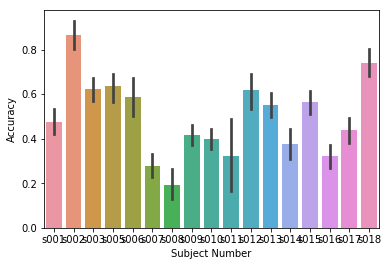

AttributeError: 'AxesSubplot' object has no attribute 'xticks'

In [107]:
print(study['subjectID'].unique())
ax = q.plot(recall_accuracy, plot_type='subject', subjname='Subject Number', subjgroup=['s001', 's002', 's003', 's005', 's006', 's007', 's008', 's009', 's010', 's011', 's012', 's013', 's014', 's015', 's016', 's017', 's018', 's019'])
ax.xticks(rotation=90)

## Serial Position Curve

The proportion of words recalled as a function of list position and list composition.

In [84]:
spc = q.analyze(egg, analysis='spc', listgroup=['allNeutral']*8 + ['halfEmotional']*8)
spc.head()

0      1      2      3      4      5      6      7   \
Subject List                                                                    
0       allNeutral     0.500  0.125  0.625  0.500  0.375  0.625  0.500  0.250   
        halfEmotional  0.625  0.375  0.500  0.125  0.250  0.375  0.750  0.375   
1       allNeutral     0.875  1.000  0.875  1.000  1.000  0.875  0.875  1.000   
        halfEmotional  0.875  0.750  0.750  0.750  0.750  0.750  0.750  0.625   
2       allNeutral     0.625  0.625  0.750  0.625  0.500  0.500  0.625  0.750   

                          8     9  ...      14     15   16   17   18   19  \
Subject List                       ...                                      
0       allNeutral     0.625  0.75 ...   0.375  0.875  0.0  0.0  0.0  0.0   
        halfEmotional  0.250  0.50 ...   0.500  0.875  0.0  0.0  0.0  0.0   
1       allNeutral     1.000  0.75 ...   0.875  0.875  0.0  0.0  0.0  0.0   
        halfEmotional  1.000  1.00 ...   0.875  1.000  0.0  0.0  0.0  0.0   
2       allNeutral     0.500  0.50 ...   0.625  0.875  0.0  0.0  0.0  0.0   

                        20   21   22   23  
Subject List                               
0       allNeutral     0.0  0.0  0.0  0.0  
        halfEmotional  0.0  0.0  0.0  0.0  
1       allNeutral     0.0  0.0  0.0  0.0  
        halfEmotional  0.0  0.0  0.0  0.0  
2       allNeutral     0.0  0.0  0.0  0.0  

[5 rows x 24 columns]

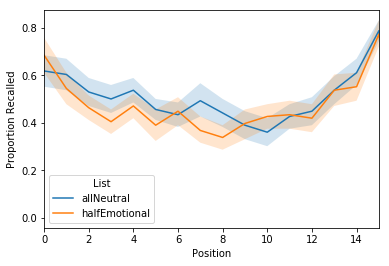

In [86]:
ax = q.plot(spc)

## Probability of First Recall

The probability of recalling a given word first as a function of word position and list composition.

In [87]:
pfr = q.analyze(egg, analysis='pfr', listgroup=['allNeutral']*8 + ['halfEmotional']*8)
pfr.head()

0      1      2      3    4    5    6      7    8   \
Subject List                                                                   
0       allNeutral     0.125  0.000  0.125  0.000  0.0  0.0  0.0  0.000  0.0   
        halfEmotional  0.125  0.000  0.000  0.000  0.0  0.0  0.0  0.000  0.0   
1       allNeutral     0.250  0.000  0.000  0.000  0.0  0.0  0.0  0.000  0.0   
        halfEmotional  0.000  0.125  0.000  0.000  0.0  0.0  0.0  0.000  0.0   
2       allNeutral     0.000  0.000  0.000  0.125  0.0  0.0  0.0  0.125  0.0   

                        9  ...      14     15   16   17   18   19   20   21  \
Subject List               ...                                                
0       allNeutral     0.0 ...   0.125  0.375  0.0  0.0  0.0  0.0  0.0  0.0   
        halfEmotional  0.0 ...   0.125  0.250  0.0  0.0  0.0  0.0  0.0  0.0   
1       allNeutral     0.0 ...   0.125  0.125  0.0  0.0  0.0  0.0  0.0  0.0   
        halfEmotional  0.0 ...   0.000  0.000  0.0  0.0  0.0  0.0  0.0  0.0   
2       allNeutral     0.0 ...   0.000  0.625  0.0  0.0  0.0  0.0  0.0  0.0   

                        22   23  
Subject List                     
0       allNeutral     0.0  0.0  
        halfEmotional  0.0  0.0  
1       allNeutral     0.0  0.0  
        halfEmotional  0.0  0.0  
2       allNeutral     0.0  0.0  

[5 rows x 24 columns]

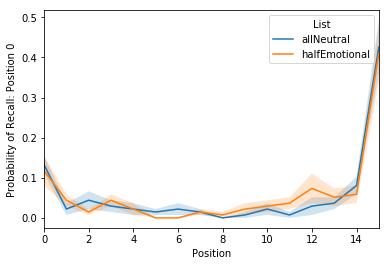

In [88]:
ax = q.plot(pfr)

## Lag-CRP

The conditional recall probability as a function of position relative to the previous recall.

In [89]:
lagcrp = q.analyze(egg, analysis='lagcrp', listgroup=['allNeutral']*8 + ['halfEmotional']*8)
lagcrp.head()

-16    -15     -14     -13     -12       -11      -10  \
Subject List                                                                   
0       allNeutral     0.0  0.000  0.0000  0.1250  0.0000  0.000000  0.00000   
        halfEmotional  0.0  0.250  0.0000  0.1875  0.0000  0.000000  0.05625   
1       allNeutral     0.0  0.000  0.0625  0.0000  0.0000  0.025000  0.00000   
        halfEmotional  0.0  0.375  0.0000  0.0000  0.0000  0.083333  0.00000   
2       allNeutral     0.0  0.000  0.2500  0.1250  0.0625  0.000000  0.00000   

                            -9        -8        -7  ...         7         8   \
Subject List                                        ...                        
0       allNeutral     0.062500  0.087500  0.083333 ...   0.041667  0.125000   
        halfEmotional  0.041667  0.020833  0.000000 ...   0.145833  0.000000   
1       allNeutral     0.000000  0.031250  0.077381 ...   0.000000  0.041667   
        halfEmotional  0.000000  0.000000  0.040625 ...   0.031250  0.000000   
2       allNeutral     0.166667  0.031250  0.062500 ...   0.000000  0.031250   

                             9         10        11   12   13     14     15  \
Subject List                                                                  
0       allNeutral     0.000000  0.041667  0.000000  0.0  0.0  0.125  0.000   
        halfEmotional  0.000000  0.000000  0.041667  0.0  0.0  0.000  0.125   
1       allNeutral     0.000000  0.000000  0.000000  0.0  0.0  0.000  0.000   
        halfEmotional  0.000000  0.000000  0.000000  0.0  0.0  0.000  0.000   
2       allNeutral     0.083333  0.166667  0.031250  0.0  0.0  0.000  0.000   

                        16  
Subject List                
0       allNeutral     0.0  
        halfEmotional  0.0  
1       allNeutral     0.0  
        halfEmotional  0.0  
2       allNeutral     0.0  

[5 rows x 33 columns]

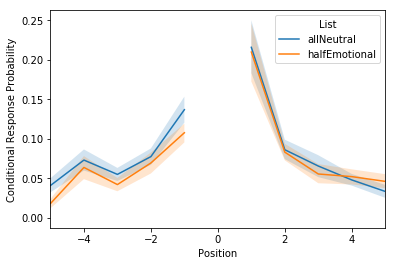

In [90]:
ax = q.plot(lagcrp)

## Temporal clustering

Temporal clustering score as a function of list composition.

Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)


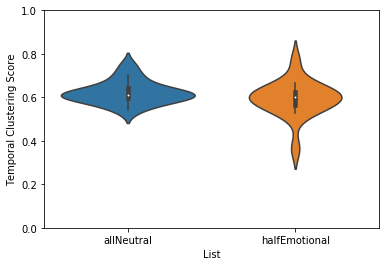

In [102]:
temporal = q.analyze(egg, analysis='temporal', listgroup=['allNeutral']*8 + ['halfEmotional']*8)
ax = q.plot(temporal, plot_style="violin" , ylim=[0,1])

In [94]:
# repeated measures ttest
t, p = stats.ttest_rel(temporal.xs('allNeutral', level='List'), temporal.xs('halfEmotional', level='List'), nan_policy='omit')

# t and p values
print('Two Sided, repeated measures t-test of List(2/8):')
print('t-value: ' + str(t[0]))
print('p-value: ' + str(p[0]))

Two Sided, repeated measures t-test of List(2/8):
t-value: 1.50021870284
p-value: 0.153031516989


## Memory Fingerprint

The likelihood subjects' clustered their recall around a particular word feature as a function of list composition.

In [95]:
fingerprint = q.analyze(egg, analysis='fingerprint', listgroup=['allNeutral']*8 + ['halfEmotional']*8)
fingerprint.head()

Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)


EmotionCategory
Subject List                          
0       allNeutral            0.538852
        halfEmotional         0.570239
1       allNeutral            0.563624
        halfEmotional         0.536346
2       allNeutral            0.543425

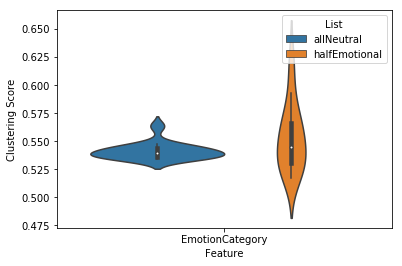

In [96]:
ax = q.plot(fingerprint)

In [98]:
# repeated measures ttest
t, p = stats.ttest_rel(fingerprint.xs('allNeutral', level='List'), fingerprint.xs('halfEmotional', level='List'), nan_policy='omit')

# t and p values
print('Two Sided, repeated measures t-test of List(2/8):')
print('t: ' + str(t[0]))
print('p: ' + str(p))

Two Sided, repeated measures t-test of List(2/8):
t: -1.22414550067
p: 0.244387997545
